In [22]:
import pandas as pd
from pmdarima.arima import nsdiffs, ndiffs
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanAbsoluteError
from sktime.split import ExpandingWindowSplitter

<Axes: >

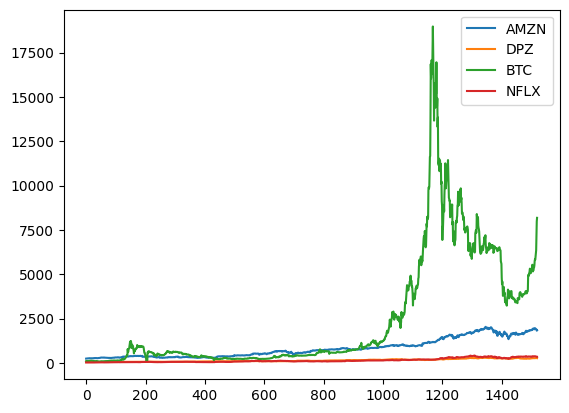

In [23]:
df = pd.read_csv('portfolio_data.csv')
df.plot()

In [24]:
df["Date"] = pd.to_datetime(df["Date"]).dt.to_period("D")
df = df.set_index(df["Date"], drop=True)
df = df.sort_index()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='BTC'>)

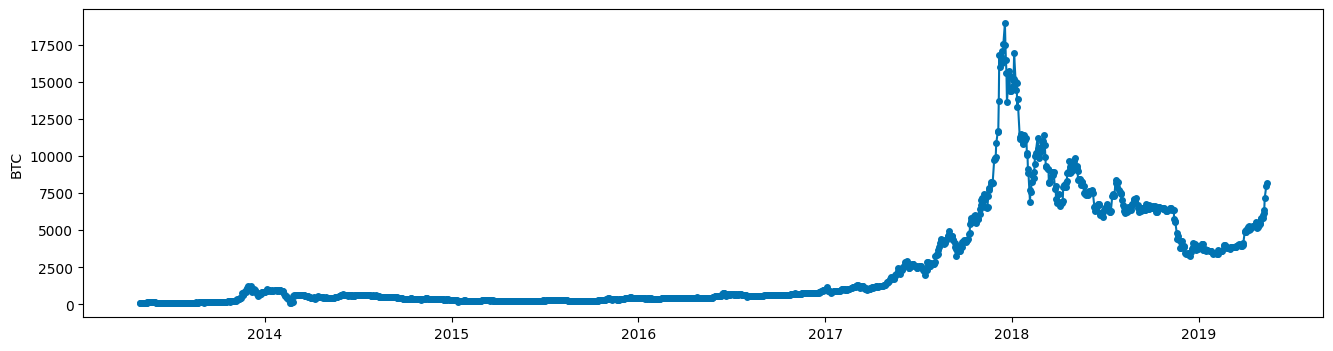

In [25]:
df = df['BTC']
plot_series(df)

## Modele ARIMA, SARIMA

Sprawdzenie sezonowości i stacjonarności

7 0
30 0
365 0
stationarity:  1


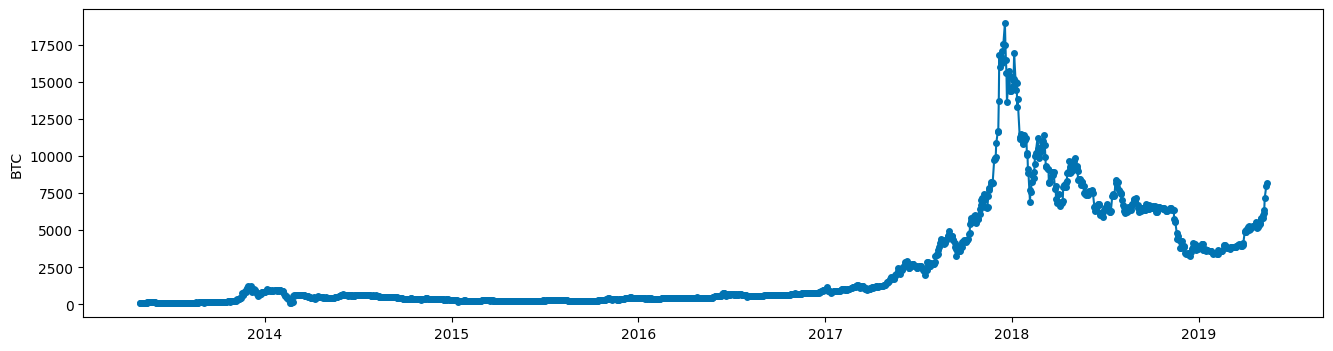

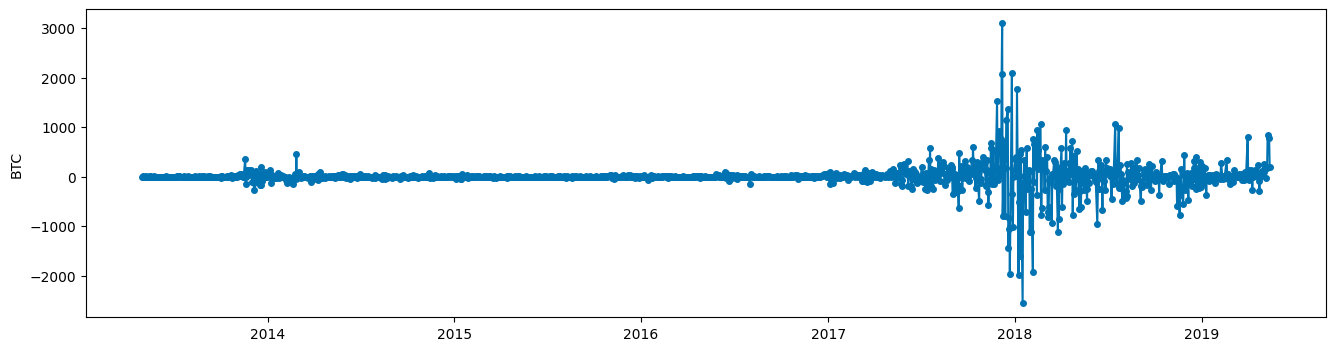

In [26]:
for d in [7, 30, 365]:
    D = nsdiffs(df, m=12)
    print(d, D)
if D > 0:
    differencer = Differencer()
    differencer.fit_transform(df)
    plot_series(df)

d = ndiffs(df)
print("stationarity: ", d)
if d > 0:
    differencer = Differencer(1)
    df_diff = differencer.fit_transform(df)
    plot_series(df)
    plot_series(df_diff)

In [27]:
def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False
) -> None:
    cv = ExpandingWindowSplitter(fh=range(1, horizon + 1), initial_window=int(0.8 * len(data)))
    metrics = [MeanAbsoluteError(), MeanAbsoluteScaledError()]
    results = evaluate(
        model, cv, data, scoring=metrics, return_data=True
    )

    mae = results["test_MeanAbsoluteError"].mean()
    mase = results["test_MeanAbsoluteScaledError"].mean()

    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")

    y_pred = pd.concat(results["y_pred"].values)
    y_pred = y_pred.sort_index()
    y_pred = y_pred[~y_pred.index.duplicated(keep='first')]

    if plot_forecasts:
        plot_series(data, y_pred)

C:\Users\Ania\PycharmProjects\StockPrediction\.venv\Lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ania\PycharmProjects\StockPrediction\.venv\Lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ania\PycharmProjects\StockPrediction\.venv\Lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ania\PycharmProjects\StockPrediction\.venv\Lib\site-packages\statsforecast\arima.py:486: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
C:\Users\Ania\PycharmProjects\StockPrediction\.venv\Lib\site-packages\sktime\performance_metrics\forecasting\_base.py:658: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y

MAE: 548.35
MASE: 6.61


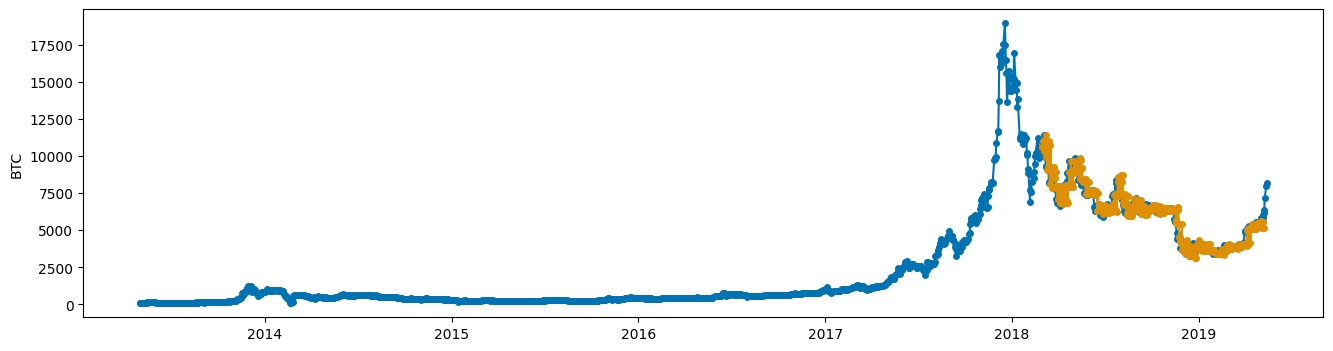

In [28]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

forecaster = StatsForecastAutoARIMA(seasonal=False)
evaluate_model(forecaster, df, horizon=14, plot_forecasts=True)